# Classification for HTRU 2 Dataset
นาย ชวศิษฐ์ เต็งไตรรัตน์ 580601631

- [HTRU 2 Dataset](https://archive.ics.uci.edu/ml/datasets/HTRU2)
- [GitHub](https://github.com/chawasit/DataMiningExercise)


## Neural Network Classification
### References
- [Why large weights are prohibited in neural networks?](https://datascience.stackexchange.com/questions/23287/why-large-weights-are-prohibited-in-neural-networks)
- [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)
- [F1 Score](https://en.wikipedia.org/wiki/F1_score)
- [Accuracy Paradox](https://en.wikipedia.org/wiki/Accuracy_paradox)
- [8 Tactics to Combat Imbalanced Classes](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)
- [Cross Entropy](https://en.wikipedia.org/wiki/Cross_entropy#Cross-entropy_minimization)
- [Evaluation of binary classifiers](https://en.wikipedia.org/wiki/Evaluation_of_binary_classifiers)
- [Softmax Implementation](http://peterroelants.github.io/posts/neural_network_implementation_part05/)

### Import Tools and download dataset

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.model_selection import KFold
import seaborn as sns
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.figure_factory as ff

import dataset
dataset.prepare_dataset('data')

def box_plot(matrix):
    data = []
    for i in range(matrix.shape[1]):
        data += [go.Box(y=matrix[:, i])]
    return py.iplot(data)

def confusion_matrix(y_predict, y_true):
    # http://peterroelants.github.io/posts/neural_network_implementation_part05/
    conf_matrix = metrics.confusion_matrix(y_true, y_predict, labels=None)  # Get confustion matrix
    # Plot the confusion table
    class_names = ['${:d}$'.format(x) for x in range(0, 10)]  # Digit class names
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # Show class labels on each axis
    ax.xaxis.tick_top()
    major_ticks = range(0, 10)
    minor_ticks = [x + 0.5 for x in range(0, 10)]
    ax.xaxis.set_ticks(major_ticks, minor=False)
    ax.yaxis.set_ticks(major_ticks, minor=False)
    ax.xaxis.set_ticks(minor_ticks, minor=True)
    ax.yaxis.set_ticks(minor_ticks, minor=True)
    ax.xaxis.set_ticklabels(class_names, minor=False, fontsize=15)
    ax.yaxis.set_ticklabels(class_names, minor=False, fontsize=15)
    # Set plot labels
    ax.yaxis.set_label_position("right")
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')
    fig.suptitle('Confusion table', y=1, fontsize=15)
    # Show a grid to seperate digits
    ax.grid(b=True, which=u'minor')
    # Color each grid cell according to the number classes predicted
    ax.imshow(conf_matrix, interpolation='nearest', cmap='binary')
    # Show the number of samples in each cell
    for x in range(conf_matrix.shape[0]):
        for y in range(conf_matrix.shape[1]):
            color = 'g' if x == y else 'k'
            ax.text(x, y, conf_matrix[y, x], ha="center", va="center", color=color)

File exist! skip download
Files already extracted


### Analysis

                  1             2             3             4             5  \
count  17898.000000  17898.000000  17898.000000  17898.000000  17898.000000   
mean     111.079968     46.549532      0.477857      1.770279     12.614400   
std       25.652935      6.843189      1.064040      6.167913     29.472897   
min        5.812500     24.772042     -1.876011     -1.791886      0.213211   
25%      100.929688     42.376018      0.027098     -0.188572      1.923077   
50%      115.078125     46.947479      0.223240      0.198710      2.801839   
75%      127.085938     51.023202      0.473325      0.927783      5.464256   
max      192.617188     98.778911      8.069522     68.101622    223.392140   

                  6             7             8         class  
count  17898.000000  17898.000000  17898.000000  17898.000000  
mean      26.326515      8.303556    104.857709      0.091574  
std       19.470572      4.506092    106.514540      0.288432  
min        7.370432     -3.13927

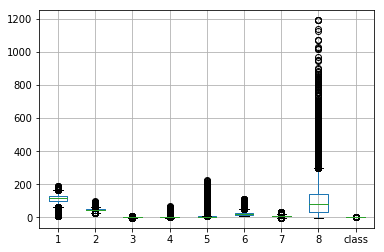

In [206]:
df = pd.read_csv('data/HTRU_2.csv', header=None, names=['1', '2', '3', '4', '5', '6', '7', '8', 'class'])
print(df.describe())
df.boxplot()

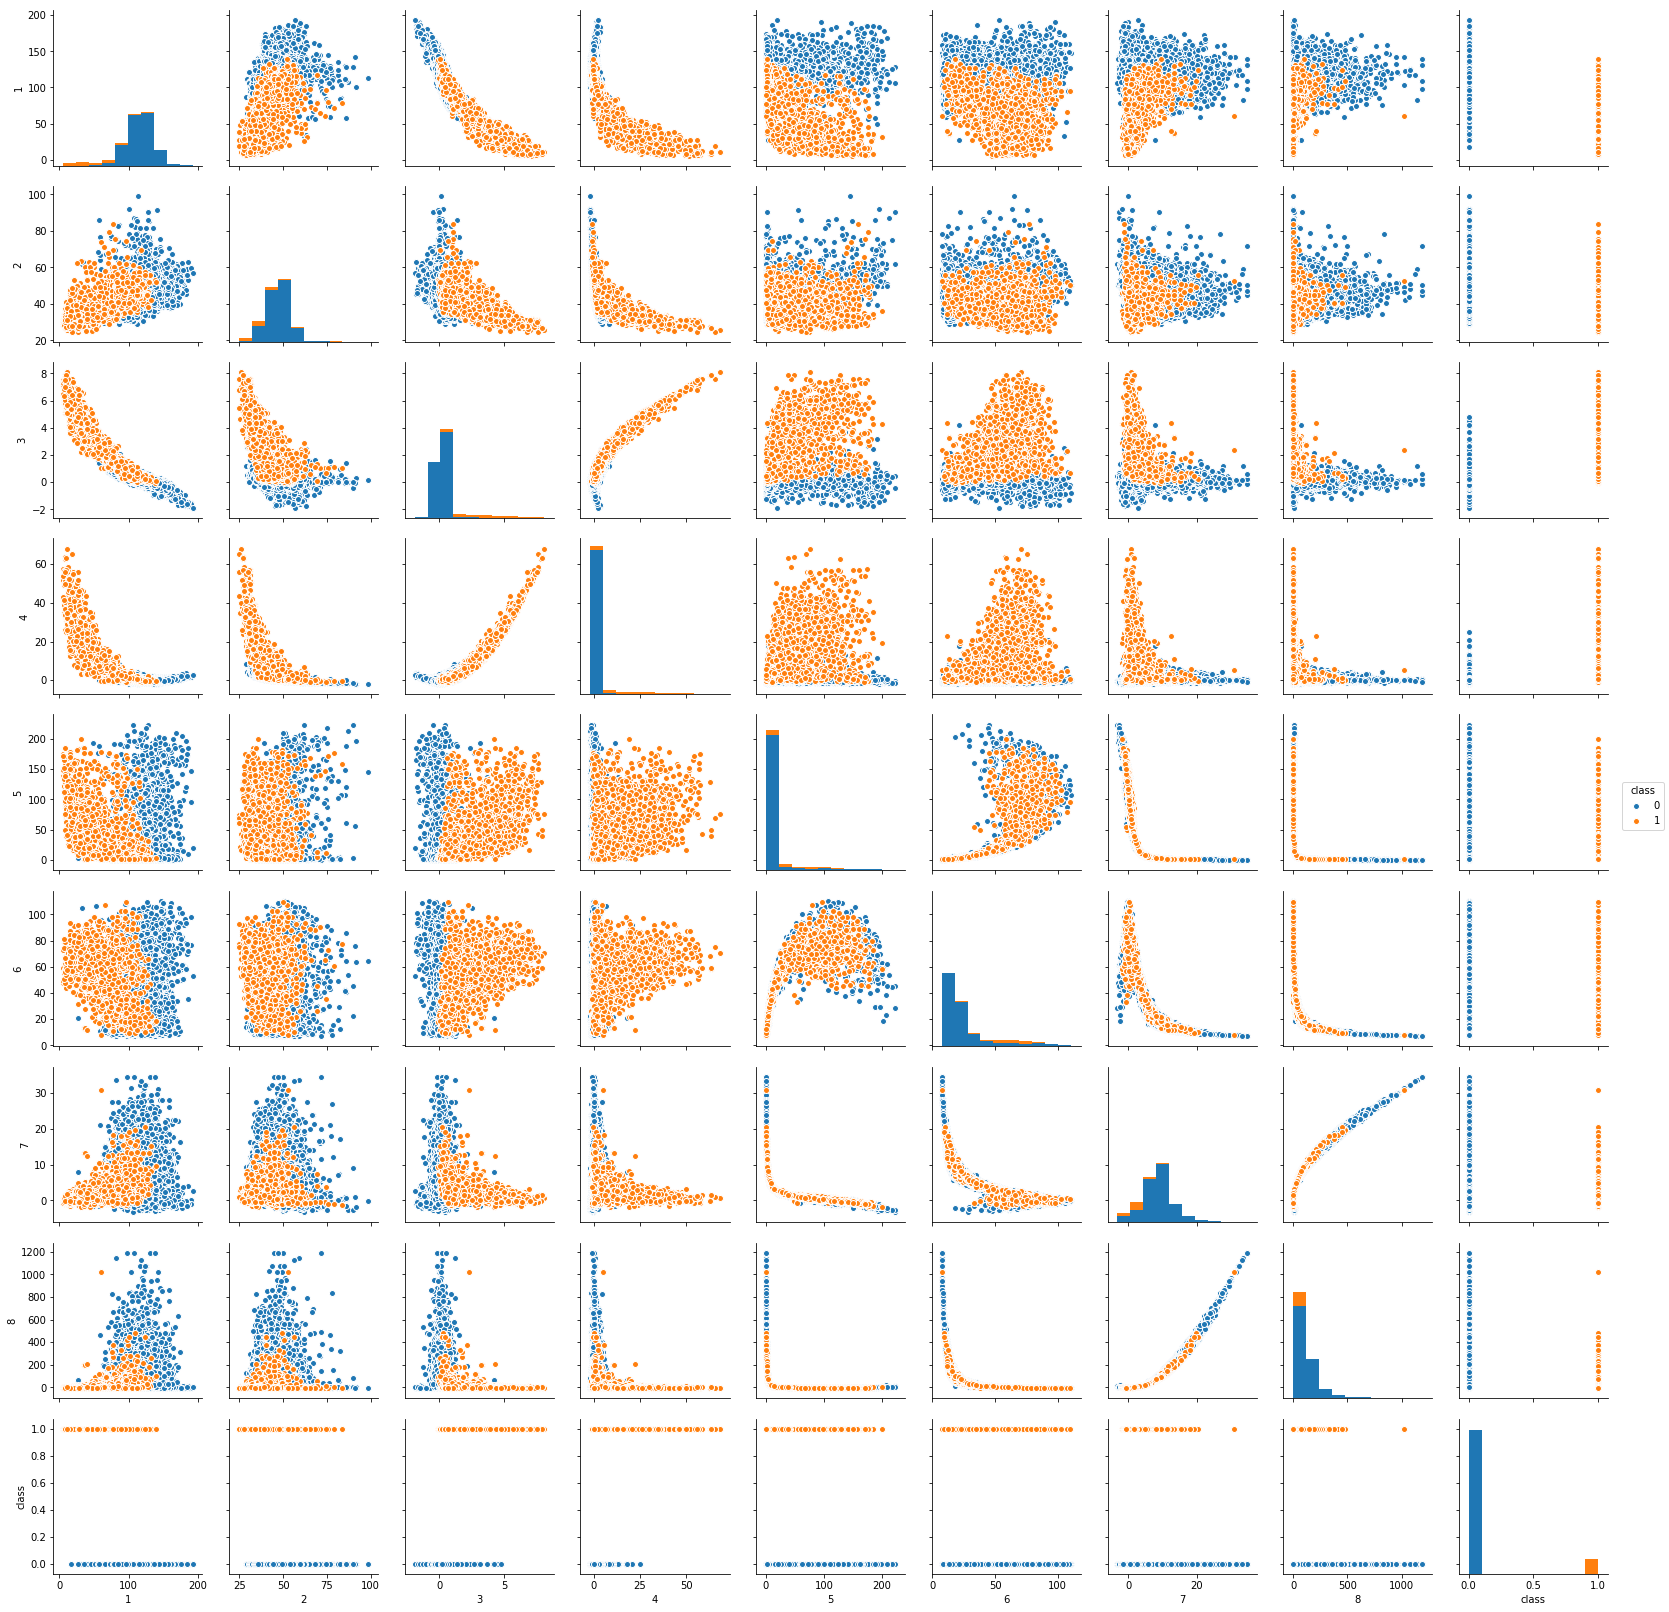

In [3]:
sns.pairplot(df, hue="class")

### Define Neural Network

ทำการสร้าง class ของ neural network เพื่อให้ง่ายต่อการปรับแต่งใช้งาน แบ่งเป็น 2 ส่วนหลัก คือ

- LinearLayer ที่กำหนดจำจำนวน nodes ในแต่ละ Layer
- ActivationLayer ใช้ในการกำหนด activation function ซึ่งมี Sigmoid, Tanh, Relu

ในแต่ละ Layer จะมี 2 การทำงานคือ forward สำหรับการ feed forward ค่าใน node ไป layer ถัดไป และ backward สำหรับการทำ back propagation
ในการคำนวณจะใช้ numpy library ในก่รคำนวณ matrix และ vector ให้ใกล้เคียงกับสมการคณิตศาสตร์

Cost/Loss Function ใช้สำหรับการฝึกสอน ในที่นี้ใช้ mean square error และ cross entropy

และคำสั่งสำหรับการฝึกสอน 3 รูปแบบ คือ
- Stochastic
- Batch
- Mini Batch

In [4]:
def mean_square_error(hypothesis, desired, derivative=False):
    if derivative:
        return hypothesis - desired

    loss = hypothesis - desired
    cost = np.sum(loss ** 2) / (2 * desired.shape[0])

    return cost


def cross_entropy(y_predict, y_true):
    return - np.multiply(y_true, np.log(y_predict)).sum() / y_predict.shape[0]


def add_bias(x, bias):
    return np.concatenate((x, bias), axis=1)


def extend_input_bias(x):
    bias = np.ones((len(x), 1), dtype=x.dtype)

    return add_bias(x, bias)


class Layer(object):
    def forward(self, input):
        raise NotImplementedError

    def backward(self, input, gradient, learning_rate):
        raise NotImplementedError


class LinearLayer(Layer):
    def __init__(self, number_of_input, number_of_node, scale=1):
        self.weight = (np.random.random((number_of_input + 1, number_of_node)) - 0.5) * 2 * scale

    def forward(self, input):
        input = extend_input_bias(input)
        return input.dot(self.weight)

    def backward(self, input, gradient, learning_rate):
        input = extend_input_bias(input).T
        delta_w = input.dot(gradient)

        self.weight += -learning_rate * delta_w

        return gradient.dot(self.weight[:-1].T)


class ReluActivation(Layer):
    @staticmethod
    def relu(x, alpha=1e-2, derivative=False):
        if derivative:
            x[x > 0] = 1
            x[x <= 0] = alpha

        x[x <= 0] = x[x <= 0] * alpha
        return x

    def forward(self, input):
        return self.relu(input)

    def backward(self, input, gradient, learning_rate=None):
        output = self.forward(input)
        return self.relu(output, derivative=True) * gradient


class SigmoidActivation(Layer):
    @staticmethod
    def sigmoid(x, derivative=False):
        if derivative:
            return x * (1 - x)

        return 1 / (1 + np.exp(-x))

    def forward(self, input):
        return self.sigmoid(input)

    def backward(self, input, gradient, learning_rate=None):
        output = self.forward(input)
        return self.sigmoid(output, derivative=True) * gradient


class TanhActivation(Layer):
    @staticmethod
    def tanh(x, derivative=False):
        if derivative:
            return 1 - x ** 2

        return np.tanh(x)

    def forward(self, input):
        return self.tanh(input)

    def backward(self, input, gradient, learning_rate=None):
        output = self.forward(input)
        return self.tanh(output, derivative=True) * gradient


class SoftmaxActivation(Layer):
    # http://peterroelants.github.io/posts/neural_network_implementation_part05/

    @staticmethod
    def softmax(x):
        return np.exp(x) / np.exp(x).sum(axis=1, keepdims=True)

    def forward(self, input):
        return self.softmax(input)

    def backward(self, input, target, learning_rate=None):
        output = self.forward(input)
        return (output - target) / output.shape[0]


class InputLayer(Layer):
    def __init__(self):
        self.variable = None

    def set(self, input):
        self.variable = input

    def forward(self, input):
        return self.variable

    def backward(self, input, gradient, learning_rate):
        pass


def forward(layers):
    input = layers[0]
    outputs = [input.forward(None)]

    for layer in layers[1:]:
        x = outputs[-1]
        y = layer.forward(x)
        outputs.append(y)

    return outputs


def backward(outputs, layers, error_gradient, learning_rate=1e-1):
    gradient = error_gradient
    outputs.pop()
    for layer in reversed(layers[1:]):
        output = outputs.pop()
        gradient = layer.backward(output, gradient, learning_rate)

        
def f1_score(y_predict, y_true):
    return metrics.f1_score(y_true, y_predict)
               
    
def train_batch(x, y, nn_layers, learning_rate):
    nn_layers[0].set(x)
    outputs = forward(nn_layers)
    y_predict = outputs[-1]

    backward(outputs, nn_layers, y, learning_rate)

    return cross_entropy(y_predict, y)


def train_stochastic(x, y, nn_layers, learning_rate):
    size = x.shape[0]
    idx = np.arange(size)
    np.random.shuffle(idx)
    loss = 0

    for i in idx:
        input_train = np.array([x[i]])
        class_train = np.array([y[i]])
        loss += train_batch(input_train, class_train, nn_layers, learning_rate)

    return loss / size


def train_minibatch(x, y, nn_layers, learning_rate, batch_size=10):
    n_batch = x.shape[0] / batch_size
    batches = zip(
        np.array_split(x, n_batch, axis=0)
        , np.array_split(y, n_batch, axis=0)
    )
    loss = 0
    for x, y in batches:
        loss += train_batch(x, y, nn_layers, learning_rate)

    return loss / n_batch


def predict(x, nn_layers):
    nn_layers[0].set(x)
    outputs = forward(nn_layers)
    y_predict = outputs[-1]

    return y_predict


def translate_class(x):
    x = x.copy()

    return np.argmax(x, axis=1)

### Pre-process Tools

ส่วนนี้จะเป็น class สำหรับการ pre process มี 2 คำสั่ง คือ 
- fit สำหรับตำนวณลักษณะของข้อมูล และเก็บไว้
- transform สำหรับการแปลงข้อมูลจากข้อมูลลักษณ์ที่เก็บไว้จาก fit

In [5]:
class StandardScaler(object):
    def __init__(self
                 , center_mean=True):
        self.center_mean = center_mean
        self.is_fit = False
        self.mean = self.mean2 = self.std = self.max = self.min = self.reference_data = None

    def fit(self, matrix):
        matrix = matrix.copy()
        try:
            self.mean = self.mean2 = matrix.mean(axis=0)
            if self.center_mean:
                for i in range(matrix.shape[1]):
                    matrix[:, i] -= self.mean[i]
                self.mean2 = matrix.mean(axis=0)
    
            self.std = matrix.std(axis=0)
            self.max = matrix.max(axis=0)
            self.min = matrix.min(axis=0)

            self.is_fit = True
            return True
        except Exception as e:
            print(e)
            return False

    def transform(self, matrix
                  , scale_to_range=None):

        if not self.is_fit:
            raise Exception('Scaler is not fit yet')

        matrix = matrix.copy()
        for i in range(matrix.shape[1]):
            if self.center_mean:
                matrix[:, i] -= self.mean[i]

            if scale_to_range is not None:
                a_min, a_max = scale_to_range
                matrix[:, i] = (matrix[:, i] - self.min[i]) \
                               / (self.max[i] - self.min[i]) \
                               * (a_max - a_min) \
                               + a_min

            else:
                matrix[:, i] = (matrix[:, i] - self.mean2[i]) / self.std[i]

        return matrix

### Read dataset and test pre-processing

ทดสอบอ่านข้อมูล และทำการทดสอบ pre-process 
class label จะถูกแปลงจาก 1 attribute ซึ่งมีค่า 0 และ 1 ออกเป็น one-hot vector เพื่อใช้สอดคล้องกับ Softmax

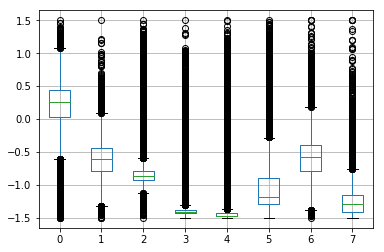

In [204]:
df = pd.read_csv('data/HTRU_2.csv', header=None, names=['1', '2', '3', '4', '5', '6', '7', '8', 'class'])
input_matrix = df[['1', '2', '3', '4', '5', '6', '7', '8']].as_matrix()

raw_class_label = df[['class']].as_matrix()
class_label = np.zeros((raw_class_label.shape[0], 2))
class_label[np.arange(raw_class_label.shape[0]), raw_class_label[:, 0]] = 1

scaler = StandardScaler()
scaler.fit(input_matrix)
normalized = scaler.transform(input_matrix, scale_to_range=(-1.5, 1.5))

pd.DataFrame(normalized).boxplot()

### กำหนดโครงสร้าง Neural Network

โครงสร้างของ Neural Network มีทั้งหมด 4 layers ดังนี้

- Input มีทั้งหมด 8 nodes สำหรับ 8 Attributes 
- Hidden Layer 1 มีทั้งหมด 16 nodes ใช้ Tanh เป็น activation function
- Hidden Layer 2 มีทั้งหมด 2 nodes ใช้ Tanh เป็น activation function
- Ouput Layer มีทั้งหมด 2 nodes ใช้ Softmax เป็น activation function

โดย weight จะมีค่าสัมบูรณ์ไม่เกิน 2 หารด้วยหารด้วยจำนวนโหนดของเลเยอร์ก่อนหน้า เพื่อป้องกันการอื่มตัวของ activation function จากผลรวมของ Linear Layer ที่มากหรือน้อยเกินไป

In [17]:
neural_network = [
    InputLayer()
    , LinearLayer(8, 16, 0.125)
    , TanhActivation()
    , LinearLayer(16, 2, 0.125)
    , TanhActivation()
    , SoftmaxActivation()
]

### Train Parameters

ในการฝึกสอนจะใช้ mini batch (batch size 32)เพื่อเพื่มความเร็วในการฝึกสอน และใช้ 10 fold cross validation ตรวจสอบความถูกต้อง

ทดสอบใช้ learning rate ทั้งหมด 5 ตัว คือ 1, 1e-1, 1e-2, 1e-3 และ 1e-4
โดยกำหนด criteria ในการหยุดการฝึกสอน 2 ตัว คือ
1. เมื่อ epoch เกินกว่า 500
2. อัตราการเปลี่ยนแปลงของ cost น้อยกว่า 1e-5

In [24]:
kf = KFold(n_splits=10)
learning_rate_list = [5, 3, 1, 1e-1, 1e-2]
batch_size = 32
max_epoch = 500
minimum_moving_cost = 1e-5

### Training

ในการฝึกสอนจะใช้ F1 Score เป็นตัวชี้วัด(ใช้วิธีเฉลี่ยคะแนนแต่ละ label) เนื่องจาก class ของข้อมูลไม่บาลานซ์ คือมีอัตราส่วนอยู่ 9:1 ซึ่งส่งให้ต่อการคิดคะแนน และการเรียนรู้ของ network
จะการทดลองฝึกสอน neural network ด้วย 10 fold cross validation และทำการทดลองเปลี่ยน learning rate และเก็บ model ที่ให้ f1 score สูงสุด

*แต่ละรอบในการฝึกสอนจะใช้ weight ตั้งต้นเหมือนกันทั้งหมด

จากโครงสร้าง neural network ในการฝึกสอนแต่ละรอบ fold จะทำการ normalize ทุก attributes โดยการทำ center mean และปรับสเกลให้อยู่ในช่วง -1.5 ถึง 1.5 ซึ่งอยู่ภายใต้ขอบเขต input ของ Tanh -2 ถึง 2 เพื่อไม่ให้เกิดการอื่มตัวในชั้น input

In [27]:
import copy

score_matrix = np.zeros((len(learning_rate_list), 10))

best_average_model = None
best_average_scaler = None
best_average_score = 0
best_learning_rate = None

for li, learning_rate in zip(range(len(learning_rate_list)), learning_rate_list):
    fold = 0
    best_score = 0
    best_scaler = None
    best_model = None
    for train_index, test_index in kf.split(input_matrix):
        fold += 1
        input_train, class_train = input_matrix[train_index], class_label[train_index]
        input_test, class_test = input_matrix[test_index], class_label[test_index]

        # fir scale to train data
        train_normalizer = StandardScaler()
        train_normalizer.fit(input_train)
        
        # Normalize train data
        input_train = train_normalizer.transform(
            input_train
            , scale_to_range=(-1.5, 1.5)
        )
        
        # Normalize test data
        input_test = train_normalizer.transform(
            input_test
            , scale_to_range=(-1.5, 1.5)
        )

        nn_layers = copy.deepcopy(neural_network)
    
        cost = np.inf
        moving_cost = np.inf
        epoch = 0

        while epoch <= max_epoch and moving_cost > minimum_moving_cost:
            new_cost = train_minibatch(input_train, class_train, nn_layers, learning_rate, batch_size=batch_size)
    
            if np.isinf(cost):
                moving_cost = cost = new_cost
            else:
                old_cost = cost
                cost = 0.75 * cost + 0.25 * new_cost
                moving_cost = 0.75 * moving_cost + 0.25 * np.abs(old_cost - cost)
            epoch += 1
        
        output = predict(input_test, nn_layers)
        score = f1_score(translate_class(output), translate_class(class_test))
        score_matrix[li, fold-1] = score

        if score > best_score:
            best_score = score
            best_model = nn_layers
            best_scaler = train_normalizer
        
    average_score = np.average(score_matrix[li])
    print(f"Learning rate: {float(learning_rate):.4}, Average F1 Score: {average_score:.6}")
    if average_score > best_average_score:
        best_average_score = average_score
        best_average_model = best_model
        best_average_scaler = best_scaler
        best_learning_rate = learning_rate

Learning rate: 5.0, Average F1 Score: 0.82327
Learning rate: 3.0, Average F1 Score: 0.837831
Learning rate: 1.0, Average F1 Score: 0.836292
Learning rate: 0.1, Average F1 Score: 0.836534
Learning rate: 0.01, Average F1 Score: 0.824652


### Best Model Evaluation

จากผลการทดสอบได้ว่า laerning rate 3 ให้ average F1 score สูงที่สุด และจากการทดสอบกับ dataset ทั้งหมด ได้ F1 score 0.879

The best learning rate is 3
Dataset F1 Score: 0.879663


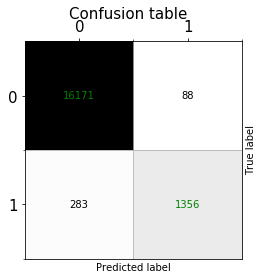

In [29]:
model = copy.deepcopy(best_average_model)
scaler = copy.deepcopy(best_average_scaler)

normalized_input_matrix = scaler.transform(input_matrix, scale_to_range=(-1.5, 1.5))

output = predict(normalized_input_matrix, model)
score = f1_score(translate_class(output), translate_class(class_label))

print(f"The best learning rate is {best_learning_rate}")
print(f"Dataset F1 Score: {score:.6}")
confusion_matrix(translate_class(output), translate_class(class_label))

### Weight inside Layers

weight อยู่ในรูปแบบ matrix โดย row index คือ index ของ node ใน layer ก่อนหน้า และ column index คือ index ของ node ใน layer ปัจจุบัน โดยมี bias อยู่ที่ row สุดท้าย

[[w11 w12]

 [w21 w22]

 [b1 b2]]

In [31]:
for layer in model:
    if type(layer) is LinearLayer:
        print(layer.weight)

[[ 4.13617083e+00  1.83562949e+00 -3.80690295e+00  2.95937457e+00
   3.08752806e+00 -2.87205074e+00 -5.82240030e-01 -3.39797601e-01
   3.66789261e+00 -6.81211083e-04 -2.23223115e+00 -3.51558959e-01
   4.89044782e-01 -1.24899087e+00 -6.43975618e-01  2.49322239e+00]
 [ 7.12410714e+00  2.83978648e+00 -1.37051951e+00  6.24909521e+00
   1.05692179e-01 -1.14790764e+00 -3.38049916e+00 -6.40404471e+00
   7.59013420e-01 -3.62278750e-01 -8.57585998e-01  1.67656356e+00
  -1.32425595e-01  1.52398402e-01  6.15437708e-02 -8.11427823e-01]
 [-8.40500254e+00 -4.52616293e+00  6.03221924e+00  4.36479190e+01
   2.74027450e+01 -2.98056532e+01  1.85316006e+00  5.32657475e+00
   2.98021090e+01 -7.96839066e-01  8.41430243e+00 -1.86918238e+00
  -1.11859320e+00  1.74865562e+00  1.16646163e+00 -2.46484965e+00]
 [-1.68834869e+00 -2.06461583e+00  1.82296285e+00 -3.00048400e+00
  -9.19214754e-01  4.05867429e-01  1.22809711e+00  1.00816086e+00
   2.10363313e-01 -1.17439492e+00  1.29866798e+00  8.63804554e-01
  -1.72

## Decision Tree (C4.5 Algorithm)

### References

- [Improved use of continuous attributes in C4.5 (1996)](https://dl.acm.org/citation.cfm?id=1622742)
- [Can C4.5 handle continuous attributes?](https://stats.stackexchange.com/questions/120659/can-c4-5-handle-continuous-attributes)
- [Entropy](https://en.wikipedia.org/wiki/Entropy_(information_theory)

In [202]:
def expected_information(data, label):
    unique_counts = data[label].value_counts().values
    size = data.shape[0]
    return -sum([
        (count / size) * np.log2(count / size)
        for count in unique_counts
    ])

def information(data, column, label):
    data = data[[column, label]]
    size = data.shape[0]
    unique_labels = data[label].unique()
    unique_datas = data[column].unique()
    
    info_score = 0
    for u_data in unique_datas:
        data_count = data[data[column] == u_data].count()[0]
        sub_data = data[data[column] == u_data]
        info_score += (data_count / size) * expected_information(sub_data, label)
        
    return info_score

def information_gain(data, column, label):
    return expected_information(data, label) - information(data, column, label)

def split_info(data, column):
    return expected_information(data, column)

def gain_ratio(data, column, label):
    return infomation_gain(data, column, label) / split_info(data, column)

test = pd.DataFrame(data=np.array([
    ['no', 'no'], ['no', 'no'], ['no', 'yes'], ['no', 'yes']
    , ['yes', 'yes'], ['yes', 'no'], ['yes', 'yes'], ['no', 'no']
    , ['yes', 'yes'], ['yes', 'yes'], ['yes', 'yes'], ['no', 'yes']
    , ['yes', 'yes'], ['no', 'no']
]))

test2 = pd.DataFrame(data=np.array([
    ['high', 'no'], ['high', 'no'], ['high', 'yes'], ['medium', 'yes']
    , ['low', 'yes'], ['low', 'no'], ['low', 'yes'], ['medium', 'no']
    , ['low', 'yes'], ['medium', 'yes'], ['medium', 'yes'], ['medium', 'yes']
    , ['high', 'yes'], ['medium', 'no']
]))

print(expected_information(test, 1))
print(information(test, 0, 1))
print(infomation_gain(test, 0, 1))

print(infomation_gain(test2, 0, 1))
print(split_info(test2, 0))
print(gain_ratio(test2, 0, 1))

0.9402859586706311
0.7884504573082896
0.15183550136234159
0.02922256565895487
1.5566567074628228
0.018772646222418813


### Node Attributes

เนื่องจากข้อมูลเป็น continuous data ทั้งหมดจึงตั้งเป้าในทดสอบว่าการทำ information gain บนข้อมูลที่ถูก split ให้ผลดีที่ดีหรือไม่ ตัว Tree จะเป็น binary tree เพราะในแต่ละ node จะมีได้แค่ 2 รูปแบบเท่านั้น คือ ฝั่งที่น้อยกว่า Threshold (left) และฝั่งที่มากกว่า Threshold (rright)

- is_leaf: เป็น leaf node หรือไม่
- class_label: label สุดท้าย
- attribute: ชื่อของ Attribute ที่ใช้ในการตัดสินใจ
- threshold: จุดแบ่งข้อมูล
- left: ชี้ไปยัง tree ที่มีค่าน้อยกว่า threshold
- right: ชี้ไปยัง tree ที่มีค่ามากกว่า threshold

In [ ]:
class Node(object):
    def __init__(self, is_leaf=False, attribute=None, class_label=None, threshold=None, left=None, right=None):
        self.is_leaf = is_leaf
        self.attribute = attribute
        self.class_label = class_label
        self.threshold = threshold
        self.left = left
        self.right = right

### Tree Building

เนื่องจากข้อมูลทั้งหมดเป็น continuous data จึงทดลองสร้างโดยการใช้การแบ่งข้อมูลออกเป็น 2 ส่วน โดยเลือก Threshold ที่ใช้แบ่งจากค่าใน attribute นั้น ที่ให้ information gain สูงสุดเป็นจุดแบ่ง
จากการแบ่งข้อมูลโดยใช้ information gain จึงไม่จำเป็นต้องทำ pre process ข้อมูลก่อน

กระบวนการสร้าง Tree จะใช้ recursive algorithm โดยจะหยุดทำงานเมื่อพบเงื่อนไขต่อไปนี้
- ไม่มีข้อมูลเหลือ
- ไม่มี attribute เหลือ
- ข้อมูลมี class เป็นเอกฉันท์


### **Computation Costs

เนื่องจากต้องทำการหา Threshold ที่เหมาะสมทุกครั้งในการเลือก attribute ทำให้มีการคำนวณเพิ่มขึ้นอย่างมาก และข้อมูลทั้งหมดยังเป็น continuous data อีกด้วย
ทำการปรับปรุงการทำงานในส่วนของการเลือก Threshold จากการทดสอบทุกจุดเป็นการทำข้้ามเสต็ป โดยจะทำการเลือก Threshold ทั้้งหมดไม่เกิน 250 ครั้งแต่การเลืก 1 ครั้ง

สันนิษฐานว่าการทำการปรับปรุงนี้อาจส่งผลกระทบต่อความแม่นยำของ decision tree จากการทดลองขั้นต้น ยังไม่สามารถสรุปผลได้ชัด


In [207]:
def best_splitting_threshold(data, column, label):
    sort_data = data[[column, label]].sort_values(by=[column])
    
    select_threshold = None
    min_expected_info = 0
    best_mask_data = None
    
    # move quicker
    step = int(data.shape[0] / 250) if data.shape[0] > 250 else 1
    for i in range(0, sort_data.shape[0] - 1, step):
        threshold = (sort_data[column].iat[i] + sort_data[column].iat[i+1]) / 2
        
        mask_data = data[[column, label]].copy()
        mask_data.loc[ data[column] <= threshold, column ] = 0
        mask_data.loc[ data[column] > threshold, column ] = 1
        expected_info = information_gain(mask_data, column, label)
        
        if expected_info > min_expected_info:
            min_expected_info = expected_info
            select_threshold = threshold
            best_mask_data = mask_data

    return select_threshold, best_mask_data


def spliter(data, label):
#     print("Spliter", data.shape, end=', ')
    if data.shape[0] == 0: # no data left
        return Node(is_leaf=True)
    if data.shape[1] == 1: # no attribute left using majority vote
        return Node(is_leaf=True, class_label=data[label].value_counts().idxmax())
    if data[label].value_counts().count() == 1: # all data belong the same class
        return Node(is_leaf=True, class_label=data[label].iat[0])
    
    max_gain_ratio = 0
    selected_column = None
    best_threshold = None
    for column in data.columns:
        if column == label:
            continue

        gain_ratio_score = -1
        threshold = None
        if data[column].dtype != 'O':
            threshold, mask_data = best_splitting_threshold(data, column, label)
            gain_ratio_score = gain_ratio(mask_data, column, label)
        else:
            gain_ratio_score = gain_ratio(data, column, label)
        
        if gain_ratio_score > max_gain_ratio:
            max_gain_ratio = gain_ratio_score
            selected_column = column
            best_threshold = threshold
    
#     print(max_gain_ratio, selected_column, end=', ')
    if best_threshold:
#         print(f"select attr: {selected_column} thres: {best_threshold}")
        left_data = data.loc[data[selected_column] <= best_threshold].drop(columns=[selected_column])
        right_data = data.loc[data[selected_column] > best_threshold].drop(columns=[selected_column])

        return Node(attribute=selected_column
                    , threshold=best_threshold
                    , left=spliter(left_data, label)
                    , right=spliter(right_data, label))
    else:
        raise Exception("Not implement yet")


def traverse(node, i=0):
    if node.is_leaf:
        print('--'*i, f"Class: {node.class_label}")
        return
    
    print('--'*i, f"Attr {node.attribute}, Threshold {node.threshold},")
    
    if node.left != None:
        traverse(node.left, i+1)
    
    if node.right != None:
        traverse(node.right, i+1)
        
    print('--'*i, f"}}")

    
def traverse_to_leaf(node, x):
    if node.is_leaf:
        return node.class_label
    attribute = node.attribute
    value = x[attribute]

    return traverse_to_leaf(node.left, x) if value <= node.threshold else traverse_to_leaf(node.right, x)


def predict(node, df):
    return [
        traverse_to_leaf(node, x)
        for index, x in df.iterrows()
    ]

### Build Decision Tree

ทำการสร้างต้นไม้โดยใช้ 10 Fold cross validation โดยใช้ F1 score เป็น metric วัดผลเช่นเดียวกับ Neural Network ข้างต้น และเก็บต้นไม้ที่ให้ score สูงสุดไว้

In [210]:
best_score = 0
best_tree = None
socre_list = []
fold = 0
for train_index, test_index in kf.split(input_matrix):
    fold += 1

    input_train = df.loc[train_index]
    input_test = df.loc[test_index]

    tree = spliter(input_train, 'class')
    score = f1_score(predict(root_tree, input_test), input_test['class'])
    print(f"Fold {fold}, score: {score}")
    
    socre_list.append(score)
    if score > best_score:
        best_score = score
        best_tree = tree


Fold 1, score: 0.875
Fold 2, score: 0.8817635270541082
Fold 3, score: 0.9010989010989011
Fold 4, score: 0.9266862170087975
Fold 5, score: 0.8920863309352518
Fold 6, score: 0.8862745098039215
Fold 7, score: 0.8783068783068784
Fold 8, score: 0.8461538461538463
Fold 9, score: 0.7083333333333333
Fold 10, score: 0.6296296296296297



Average F1 Score: 0.8425333173324667
Best score: 0.9266862170087975
Dataset score: 0.8850718301061836


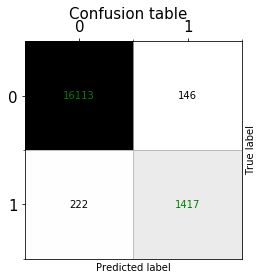

In [211]:
average_f1_score = sum(socre_list) / len(socre_list)
print(f"Average F1 Score: {average_f1_score}")
print(f"Best score: {best_score}")
dataset_f1_score = f1_score(predict(best_tree, df), df['class'])
print(f"Dataset score: {dataset_f1_score}")
confusion_matrix(predict(best_tree, df), df['class'])

### Best Decision Tree Structure

 Attr 3, Threshold 1.1387987979999998,
-- Attr 5, Threshold 8.516304347999998,
---- Attr 1, Threshold 112.9140625,
------ Attr 6, Threshold 27.324407195,
-------- Attr 4, Threshold -0.021133665,
---------- Class: 0
---------- Attr 7, Threshold 19.84618409,
------------ Attr 8, Threshold 415.23379635000003,
-------------- Attr 2, Threshold 37.44152586,
---------------- Class: 0
---------------- Class: 0
-------------- }
-------------- Attr 2, Threshold 49.397599705000005,
---------------- Class: 0
---------------- Class: 1
-------------- }
------------ }
------------ Class: 0
---------- }
-------- }
-------- Attr 4, Threshold 0.0050790455000000005,
---------- Class: 0
---------- Attr 8, Threshold 32.720126185,
------------ Attr 2, Threshold 52.545750875,
-------------- Attr 7, Threshold 5.5347700275000005,
---------------- Class: 0
---------------- Class: 0
-------------- }
-------------- Class: 1
------------ }
------------ Attr 2, Threshold 39.1861703,
-------------- Class: 0
--------

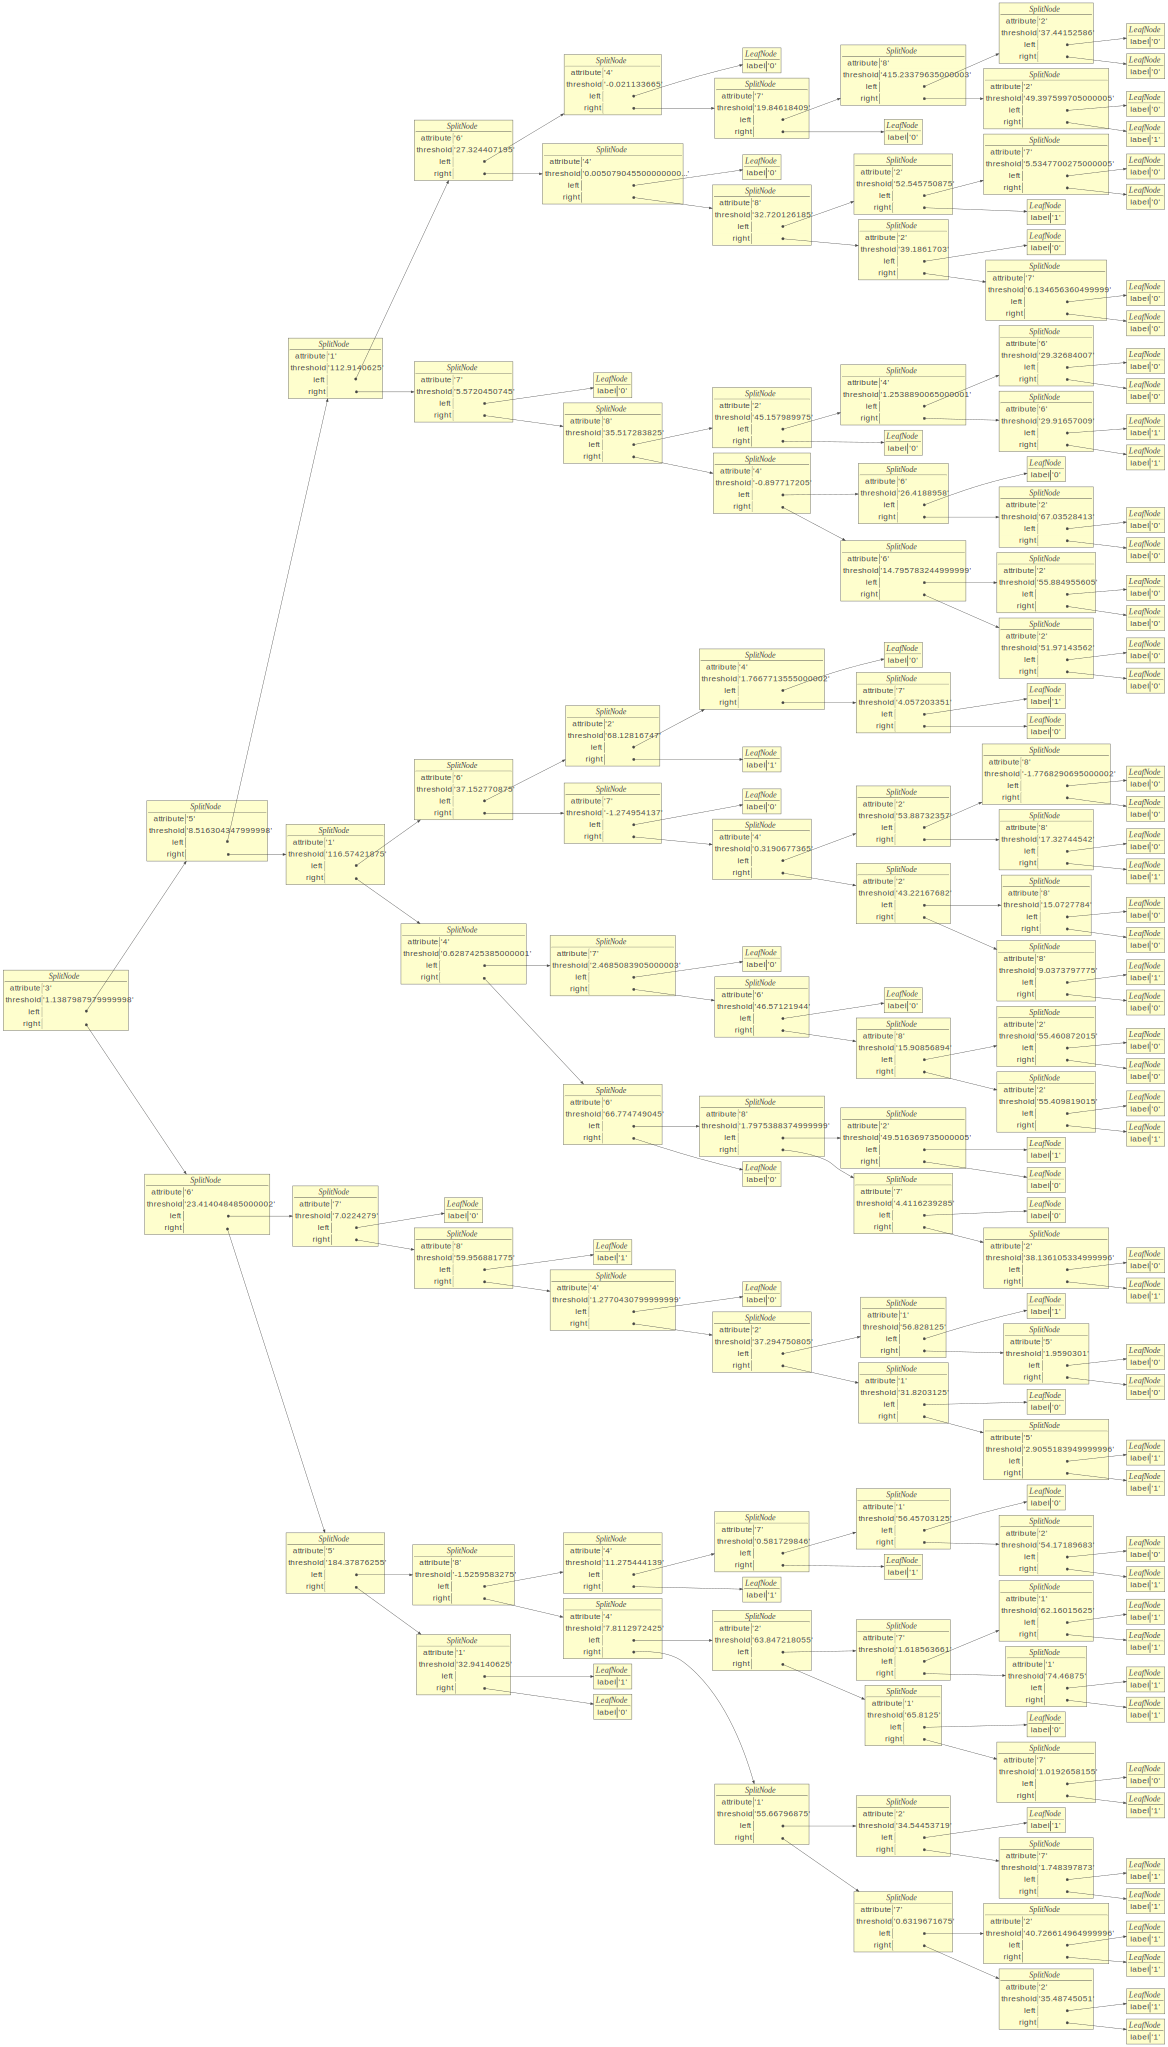

In [229]:
import lolviz

traverse(best_tree)
class LeafNode(object):
    def __init__(self, label):
        self.label = label

class SplitNode(object):
    def __init__(self, attribute, threshold, left, right):
        self.attribute = attribute
        self.threshold = threshold
        self.left = left
        self.right = right

def clean(node):
    if node.is_leaf:
        return LeafNode(str(node.class_label))
    return SplitNode(node.attribute, str(node.threshold), clean(node.left), clean(node.right))
    
tree = clean(copy.deepcopy(best_tree))

lolviz.objviz(tree)

## Conclusion

จากการทดลองข้างต้น Decision Tree และ Neural Network ให้ผลลัพท์ที่ใกล้เคียงกันมาก ทั้ง Average F1 score และ F1 score ในการทดสอบกับทั้ง Dataset

### Neural Network 

- ปรับเปลี่ยนกระบวนการ Pre process ข้อมูล
- จากการทดลองมี bias กับ label 0 (negative) ซึ่งเป็นผลมาจาก unbalance dataset อาจปรับปรุงโครงสร้างโดยการลด node ลงลดการจดจำรูปแบบการเกิด label 0 
- ปรับปรุง dataset และวิธีการเทรน เช่นการทำให้ข้อมูลในแต่ละ batch balance กัน
- ส่วนของโครงสร้าง Layer สามารถต่อยอดส่วนของการ Train และ Metric เข้าเป็นประเภทหนึ่งของ Layer ได้

### Decision Tree
- Binning ข้อมูลแทนการใช้ continuous data 
- ปรับปรุง algorithm ให้ใช้งาน memory และ cpu มีประสิทธิภาพมากขึ้น (หลีกเลี่ยง Resursion หรือใช้ accumlator แทนการเก็บข้อมูลใน stack)